In [ ]:
import os
import sys

notebook_path = os.path.abspath("")
parent_dir = os.path.dirname(notebook_path)
sys.path.append(parent_dir)
from baukit import Trace, TraceDict
from template import *
from datasets import load_dataset
from tqdm import tqdm 
from transformers import AutoModelForCausalLM,AutoTokenizer
from peft import AutoPeftModelForCausalLM
import torch
import json
from transformers import GenerationConfig,AutoConfig
import fire
from model import ActivationLLama
from datasets import load_dataset, Dataset
from typing import Optional, Union
import pdb

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6,7,8"

model_path = "/mnt/publiccache/huggingface/Meta-Llama-3-8B-Instruct"
peft_path = "/mnt/userdata/liangsirui/MyProject/Prefix/Results/Test/Llama3/9000_math10k_all_8_2e-4/test1/delta_vector.pth"
op_position = "attn_o"

model = AutoModelForCausalLM.from_pretrained(model_path,torch_dtype=torch.bfloat16,device_map="auto")

model1 = AutoModelForCausalLM.from_pretrained(model_path,torch_dtype=torch.bfloat16,device_map="auto")
model_reft = ActivationLLama(model1, op_position=op_position, prefix=-1)
model_reft.load_model(peft_path)

tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side="left", torch_dtype=torch.bfloat16)
tokenizer.padding_side = "left"
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id

In [ ]:
Question = "Mishka bought 3 pairs of shorts, 3 pairs of pants, and 3 pairs of shoes. One pair of shorts costs $16.50. One pair of pants costs $22.50 and one pair of shoes costs $42. How many dollars did Mishka spend on all the clothing items?"

template = "<|start_header_id|>user<|end_header_id|>\n\n%s Please provide the initial step towards resolving the question. This step may serve as a foundation but might not encompass the entire solution.\n\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

prompt = template % Question
prompt_ids = tokenizer(prompt, return_tensors='pt').to(model.base_model.device)

generation_config = GenerationConfig(
    do_sample=False,
    no_repeat_ngram_size=5,
    repetition_penalty=1.1,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    bos_token_id=1,
)

In [ ]:
import pickle
import numpy as np

with open("truthfulqa_probes.pkl", "rb") as f:
    probe_data = pickle.load(f)

probes = probe_data['probes']
accuracies = probe_data['accuracies']

In [ ]:
NUM_LAYERS = model.config.num_hidden_layers

with torch.no_grad():
    with TraceDict(model, [f"model.layers.{i}.self_attn.o_proj" for i in range(NUM_LAYERS)]) as base_hs:
        outputs = model(**prompt_ids)

In [ ]:
with torch.no_grad():
    with TraceDict(model_reft, [f"base_model.model.layers.{i}.self_attn.o_proj" for i in range(NUM_LAYERS)]) as reft_hs:
        outputs = model_reft(**prompt_ids)

In [ ]:
layer = 13
output = base_hs[f'model.layers.{layer}.self_attn.o_proj'].output
last_token_activation = output[0, -1, :]
probes[layer].predict(last_token_activation.reshape(1, -1).cpu().float().numpy())

In [ ]:
output.shape

In [ ]:
layer = 13
output = reft_hs[f'base_model.model.layers.{layer}.self_attn.o_proj'].output
last_token_activation = output[0, -1, :]
probes[layer].predict(last_token_activation.reshape(1, -1).cpu().float().numpy())

In [1]:
import json

def save_list_to_json(data_list, file_path):
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data_list, f, ensure_ascii=False, indent=4)  # 使用 indent 格式化 JSON
    print(f"数据已成功存储到 {file_path}")

def read_json_file(file_path):
    try:
        # 以只读模式打开文件，使用 UTF-8 编码
        with open(file_path, 'r', encoding='utf-8') as file:
            # 加载 JSON 数据
            data = json.load(file)
            return data
    except FileNotFoundError:
        print(f"文件 {file_path} 未找到。")
    except json.JSONDecodeError:
        print(f"文件 {file_path} 不是有效的 JSON 格式。")

In [2]:
# 分析get_inference_hs.py的分析结果
base_prob =  read_json_file("/mnt/userdata/MyProject/Prefix/interpretability/truthful_probe_base.json")
reft_prob =  read_json_file("/mnt/userdata/MyProject/Prefix/interpretability/truthful_probe_reft.json")

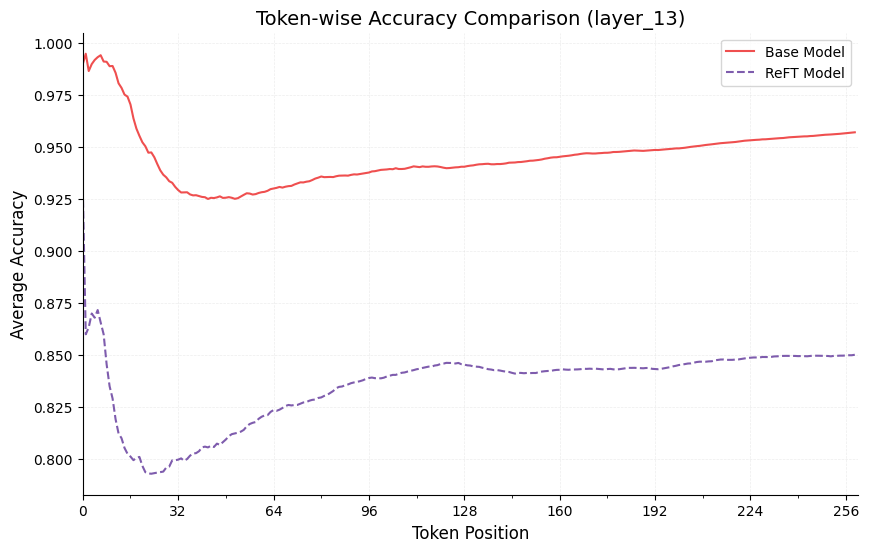

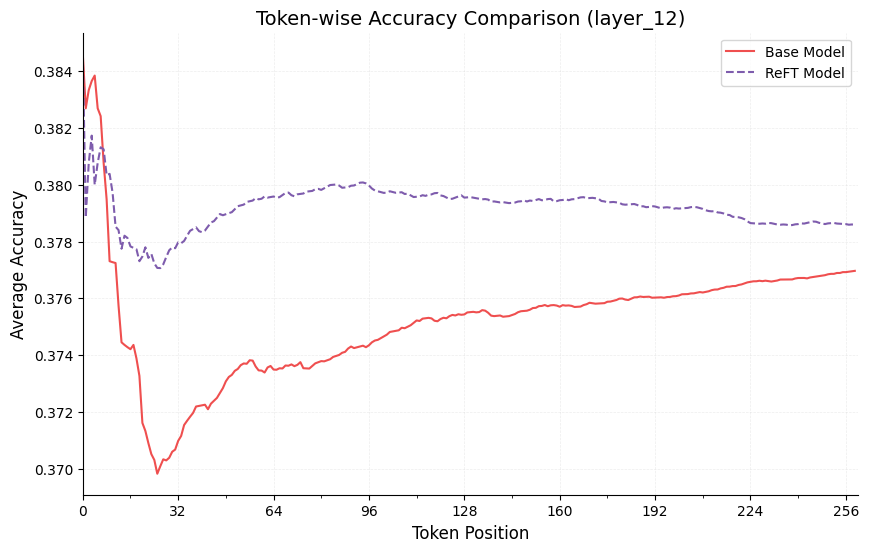

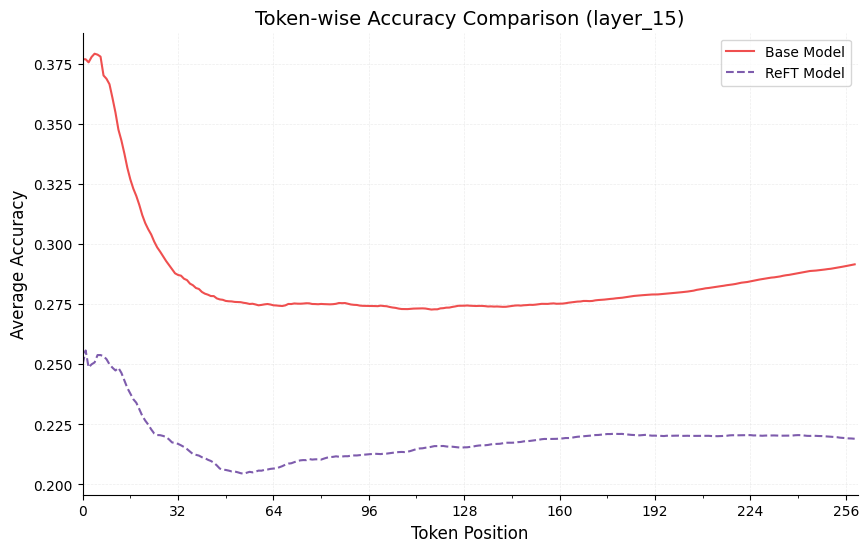

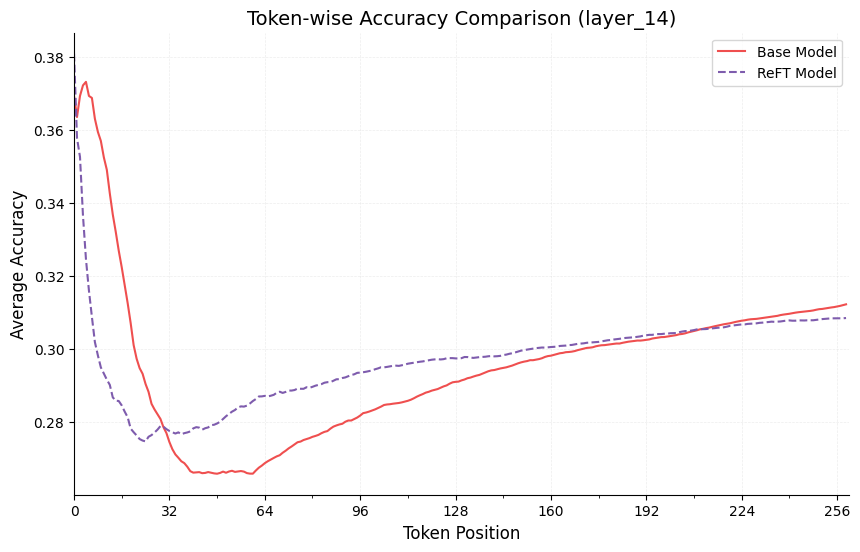

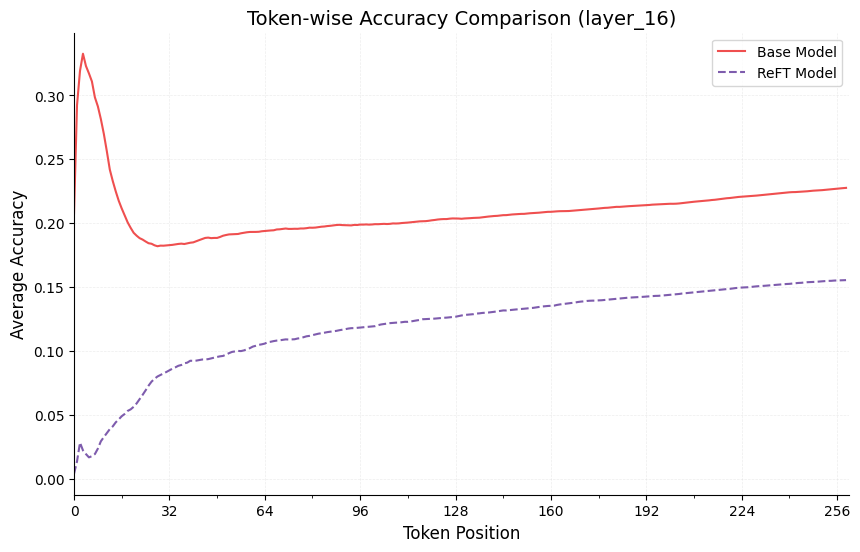

In [4]:
import matplotlib.pyplot as plt

data_length = len(base_prob.keys())
data_index_list = list(base_prob.keys())
layer_index_list = base_prob[data_index_list[0]].keys()

for layer_index in layer_index_list:
    
    all_base_acc = [0 for i in range(512)]
    all_reft_acc = [0 for i in range(512)]
    
    for data_index in base_prob.keys():
        base_layer_prob = base_prob[data_index][layer_index]
        reft_layer_prob = reft_prob[data_index][layer_index]

        base_correct = 0
        reft_correct = 0
        base_acc = []
        reft_acc = []

        for index, token_index in enumerate(base_layer_prob.keys()):
            base_token_prob = base_layer_prob[token_index]
            base_correct += base_token_prob
            current_base_acc = base_correct / (index + 1)
            base_acc.append(current_base_acc)
            
            reft_token_prob = reft_layer_prob[token_index]
            reft_correct += reft_token_prob
            current_reft_acc = reft_correct / (index + 1)
            reft_acc.append(current_reft_acc)

            all_base_acc[index] += current_base_acc
            all_reft_acc[index] += current_reft_acc

    avg_base = [acc/data_length for acc in all_base_acc]
    avg_reft = [acc/data_length for acc in all_reft_acc]

    data_length = 260
    avg_base = avg_base[:data_length]
    avg_reft = avg_reft[:data_length]

    plt.figure(figsize=(10, 6))
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='lightgray')

    # 只保留左侧和下侧框线
    ax = plt.gca()
    ax.spines['left'].set_visible(True)  # 左侧框线
    ax.spines['bottom'].set_visible(True)  # 下侧框线
    ax.spines['right'].set_visible(False)  # 右侧框线
    ax.spines['top'].set_visible(False)  # 上侧框线
        
    # 绘制折线
    colors = ['#EF4F4F', '#7E5CAD', '#7AA2E3', '#52D3D8', '#FFE699']
    plt.plot(avg_base, label='Base Model', linestyle='-', linewidth=1.5, color=colors[0])
    plt.plot(avg_reft, label='ReFT Model', linestyle='--', linewidth=1.5, color=colors[1])

    # 图表装饰
    plt.title(f'Token-wise Accuracy Comparison ({layer_index})', fontsize=14)
    plt.xlabel('Token Position', fontsize=12)
    plt.ylabel('Average Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.xlim(0, data_length)
    
    # 处理坐标轴密集问题
    plt.xticks(range(0, data_length, 32))
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(16))

    plt.savefig(f"/mnt/userdata/MyProject/Prefix/interpretability/fig/{layer_index}_comparison.svg", bbox_inches='tight', dpi=300)
    plt.show()

    # 文字输出
    # for token_index in range(512):
    #     current_base_acc = all_base_acc[token_index]
    #     current_reft_acc = all_reft_acc[token_index]
    #     print(f"Layer {layer_index}, Token {token_index}, Base Acc: {current_base_acc:.4f}, Reft Acc: {current_reft_acc:.4f}")
    

            